# Simulation of option prices using the Black-Scholes model

## Simulations on CPU
### Compilation of files

In [3]:
!make

make: Nothing to be done for 'all'.


### Execution

In [28]:
import os
import subprocess
import pandas as pd
from typing import List

# Function to execute "cpu" executables and collect results
def run_cpu_executables(build_dir, n_simul_list, simul_length_list, num_threads_list, repetitions=3, output_csv="results_cpu.csv"):
    """
    Executes executables in the build directory whose names contain "cpu".
    Aggregates results into a CSV with specified configurations.
    
    Args:
    - build_dir (str): Path to the build directory containing executables.
    - n_simul_list (list): List of n_simul values to test.
    - simul_length_list (list): List of simulation lengths to test.
    - num_threads_list (list): List of thread counts for OpenMP executables.
    - repetitions (int): Number of repetitions for each configuration.
    - output_csv (str): Output CSV file name.
    """
    results = []
    
    # Find all "cpu" executables
    cpu_executables = [f for f in os.listdir(build_dir) if "cpu" in f and os.access(os.path.join(build_dir, f), os.X_OK)]
    
    for exe in cpu_executables:
        exe_path = os.path.join(build_dir, exe)
        is_openmp = "openmp" in exe
        print(f"Executing {exe}...")
        
        # Loop over configurations
        for n_simul in n_simul_list:
            for simul_length in simul_length_list:
                # Thread handling for OpenMP
                thread_configs = num_threads_list if is_openmp else [None]
                for num_threads in thread_configs:
                    # Modify name for OpenMP threads
                    exe_name = exe if num_threads is None else f"{exe}_{num_threads}threads"
                    
                    for _ in range(repetitions):
                        # Build the command
                        cmd = [exe_path, "--nSimul", str(n_simul), "--lengthSimulation", str(simul_length)]
                        if num_threads is not None:
                            cmd += ["--nThreads", str(num_threads)]
                        
                        # Execute and capture output
                        try:
                            result = subprocess.run(cmd, capture_output=True, text=True, check=True)
                            output = result.stdout
                            
                            # Parse the elapsed time from the output
                            time_line = next((line for line in output.splitlines() if "Elapsed Time" in line), None)
                            elapsed_time = float(time_line.split(":")[1].removesuffix("seconds").strip()) if time_line else None
                            
                            if elapsed_time is not None:
                                results.append({
                                    "name": exe_name,
                                    "n_simul": n_simul,
                                    "simul_length": simul_length,
                                    "time": elapsed_time
                                })
                        except subprocess.CalledProcessError as e:
                            print(f"Error executing {exe_path}: {e}")
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

In [ ]:
build_dir = "./build"  # Path to your build directory
n_simul_list = [1000, 10000, 100000, 1000000]  # List of n_simul values
simul_length_list = [252]  # List of simulation lengths
num_threads_list = [1, 2, 8, 20]  # List of thread counts for OpenMP
repetitions = 3  # Number of repetitions for each configuration

run_cpu_executables(build_dir, n_simul_list, simul_length_list, num_threads_list, repetitions)

### Plotting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_boxplots_by_simul_length(input_csv):
    """
    Reads data from a CSV and generates boxplots for each simulation length.
    
    Args:
    - input_csv (str): Path to the input CSV file containing the results.
    
    The CSV file must have the following columns:
    - name: Program name (optionally with thread count appended).
    - n_simul: Number of simulations.
    - simul_length: Length of the simulation.
    - time: Execution time in seconds.
    """
    # Read the data
    df = pd.read_csv(input_csv)
    
    # Validate that required columns exist
    required_columns = {"name", "n_simul", "simul_length", "time"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"The CSV file must contain the following columns: {required_columns}")
    
    # Unique simulation lengths
    simulation_lengths = df["simul_length"].unique()
    
    for sim_length in simulation_lengths:
        # Filter data for this simulation length
        filtered_df = df[df["simul_length"] == sim_length]
        
        # Set up the plot
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=filtered_df,
            x="n_simul",
            y="time",
            hue="name",
            palette="Set2"
        )
        
        # Plot formatting
        plt.title(f"Execution Time for Simulation Length {sim_length}")
        plt.xlabel("Number of Simulations")
        plt.ylabel("Execution Time (seconds)")
        plt.legend(title="Program Name")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.yscale("log")
        
        # Save or show the plot
        plt.tight_layout()
        plt.savefig(f"boxplot_sim_length_{sim_length}.png")
        plt.show()

def generate_boxplots_by_n_simul(input_csv):
    """
    Reads data from a CSV and generates boxplots for each number of simulations (n_simul).
    The boxplots will group by simulation length (simul_length) and show performance of different programs.

    Args:
    - input_csv (str): Path to the input CSV file containing the results.
    
    The CSV file must have the following columns:
    - name: Program name (optionally with thread count appended).
    - n_simul: Number of simulations.
    - simul_length: Length of the simulation.
    - time: Execution time in seconds.
    """
    # Read the data
    df = pd.read_csv(input_csv)
    
    # Validate that required columns exist
    required_columns = {"name", "n_simul", "simul_length", "time"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"The CSV file must contain the following columns: {required_columns}")
    
    # Unique number of simulations
    n_simul_values = df["n_simul"].unique()
    
    for n_simul in n_simul_values:
        # Filter data for this number of simulations
        filtered_df = df[df["n_simul"] == n_simul]
        
        # Set up the plot
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=filtered_df,
            x="simul_length",
            y="time",
            hue="name",
            palette="Set2"
        )
        
        # Plot formatting
        plt.title(f"Execution Time for {n_simul} Simulations")
        plt.xlabel("Simulation Length")
        plt.ylabel("Execution Time (seconds)")
        plt.legend(title="Program Name")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        
        # Save or show the plot
        plt.tight_layout()
        plt.savefig(f"boxplot_n_simul_{n_simul}.png")
        plt.show()


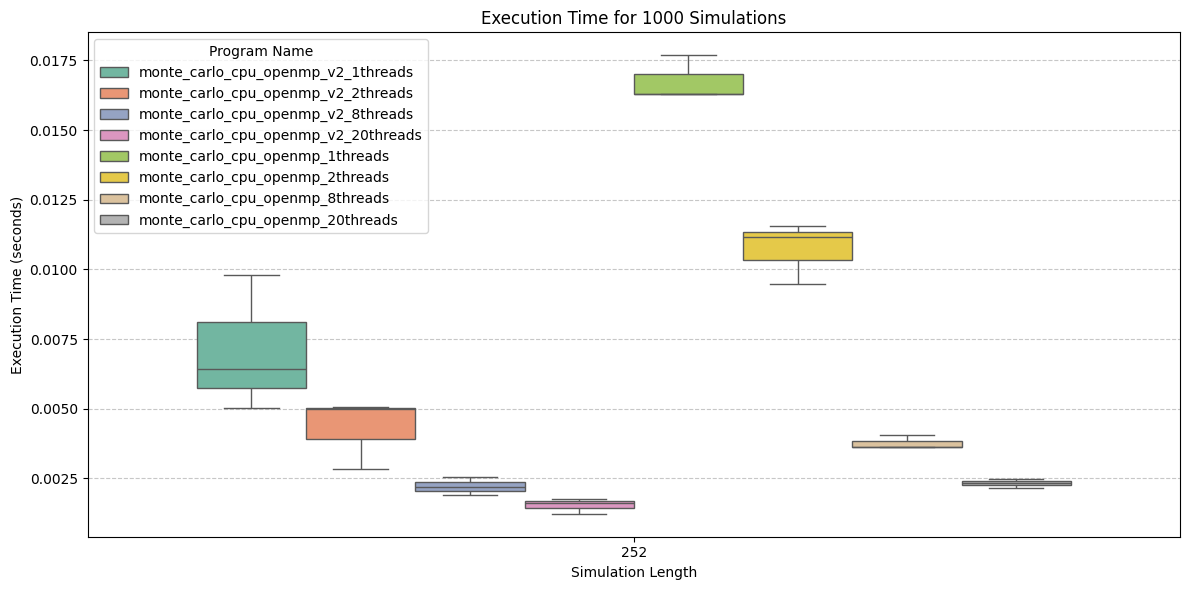

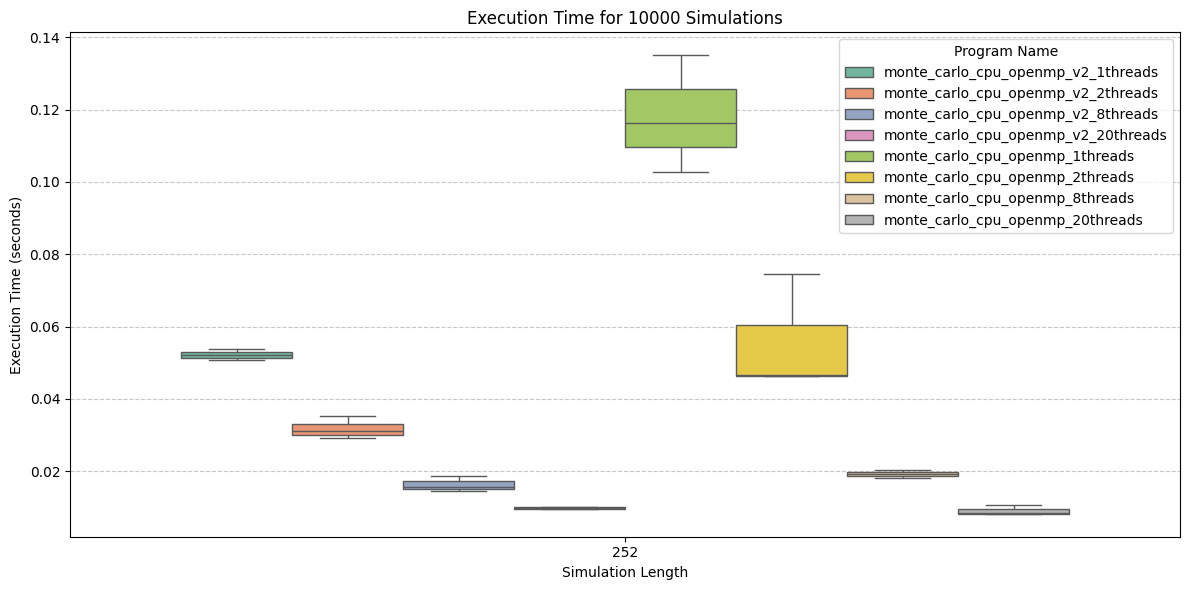

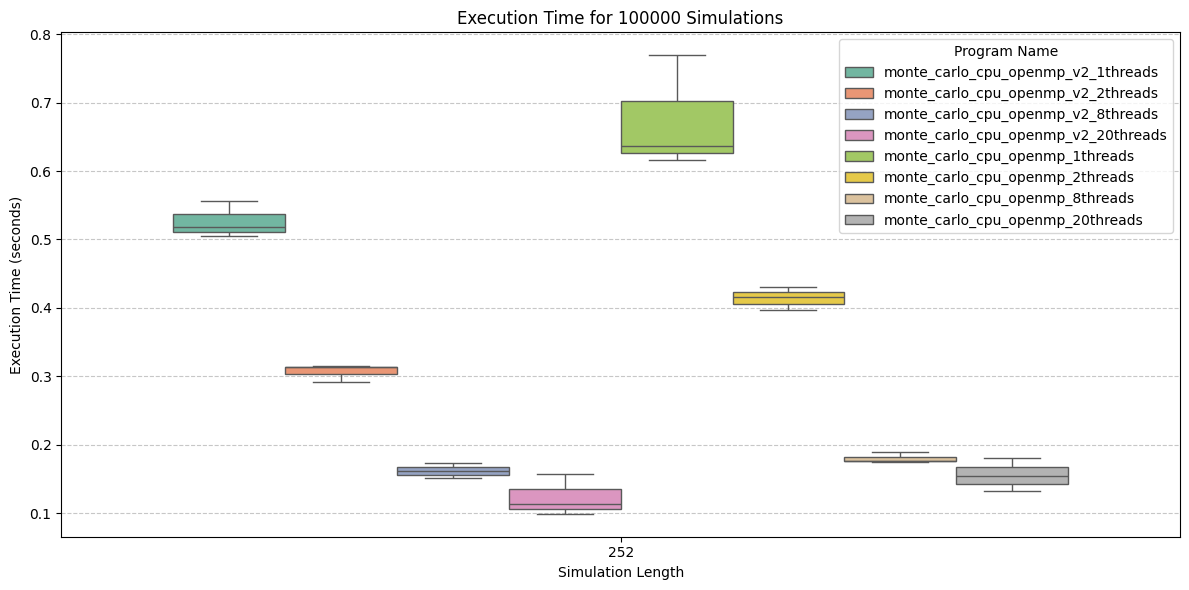

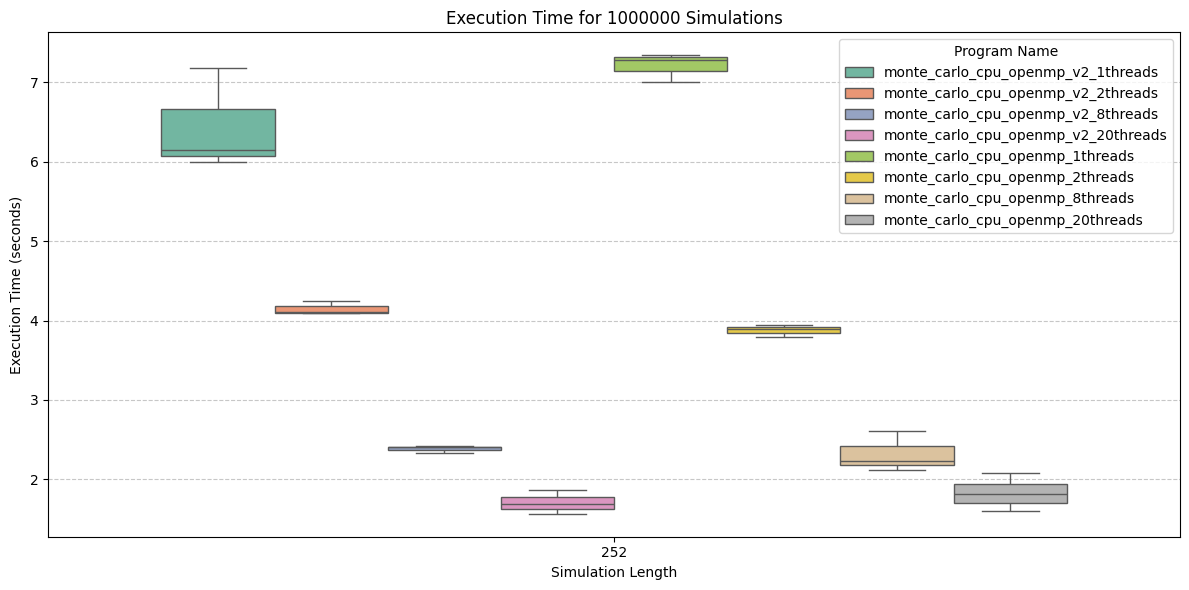

In [2]:
generate_boxplots_by_n_simul("results_cpu.csv")

In [176]:
def generate_curve_per_nb_thread(df: pd.DataFrame):
    """
    Reads data from a CSV and generates plots for each number of simulations (n_simul).
    The plots will show the execution time of two versions of the benchmarked code with
    different number of threads and error bars for both versions.

    Args:
    - input_csv (str): Path to the input CSV file containing the results.
    
    The CSV file must have the following columns:
    - name: Program name (optionally with thread count appended).
    - n_simul: Number of simulations.
    - simul_length: Length of the simulation.
    - time: Execution time in seconds.
    """
    # Unique number of simulations
    n_simul_values = df["n_simul"].unique()
    # Unique number of threads
    n_thread_values = df["n_threads"].unique()
    # Unique versions
    versions = df["version"].unique()

    for n_simul in n_simul_values:
        # Set up the plot
        plt.figure(figsize=(12, 6))

        # Filter data for this number of simulations
        filtered_df = df[(df["n_simul"] == n_simul)]

        # Plot with error bars
        g = sns.catplot(
            data=filtered_df,
            x="n_threads",
            y="time",
            hue="version",
            capsize=.2,
            palette="Set2",
            errorbar="sd",
            kind="point",
            height=6,
            aspect=1,
        )
        g.legend.set_title("Version")

        # Plot formatting
        plt.title(f"Execution Time for {n_simul} Simulations")
        plt.xlabel("Number of Threads")
        plt.ylabel("Execution Time (seconds)")
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        # Save or show the plot
        plt.tight_layout()
        #plt.savefig(f"lineplot_n_simul_{n_simul}.png")
        plt.show()


In [203]:
def generate_curve_per_nb_sim(df: pd.DataFrame):
    """
    Reads data from a CSV and generates plots for each number of threads (n_threads).
    The plots will show the execution time of two versions of the benchmarked code with
    different number of simulations and error bars for both versions.

    Args:
    - input_csv (str): Path to the input CSV file containing the results.
    
    The CSV file must have the following columns:
    - name: Program name (optionally with thread count appended).
    - n_simul: Number of simulations.
    - simul_length: Length of the simulation.
    - time: Execution time in seconds.
    """
    # Unique number of simulations
    n_simul_values = df["n_simul"].unique()
    # Unique number of threads
    n_thread_values = df["n_threads"].unique()
    # Unique versions
    versions = df["version"].unique()

    for version in versions:
        # Filter data for this number of simulations
        filtered_df = df[(df["version"] == version)]

        # Set up the plot
        plt.figure(figsize=(12, 6))

        # Plot with error bars
        g = sns.catplot(
            data=filtered_df,
            x="n_simul",
            y="time",
            hue="n_threads",
            capsize=.2,
            palette="Set2",
            errorbar="sd",
            kind="point",
            height=6,
            aspect=1,
        )

        # Plot formatting
        plt.title(f"Execution Time for Version { version}")
        plt.xlabel("Number of Simulations")
        plt.ylabel("Execution Time (seconds)")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.yscale("log")

        # Save or show the plot
        plt.tight_layout()
        #plt.savefig(f"lineplot_n_simul_{n_simul}.png")
        plt.show()


In [204]:
# Read the data
df = pd.read_csv("results_cpu.csv")

# Validate that required columns exist
required_columns = {"name", "n_simul", "simul_length", "time"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"The CSV file must contain the following columns: {required_columns}")

df["n_threads"] = df["name"].str.extract(r"(\d+)threads").astype(int)
df.loc[~df["name"].str.contains("v2"), "version"] = "v1"
df.loc[df["name"].str.contains("v2"), "version"] = "v2"


<Figure size 1200x600 with 0 Axes>

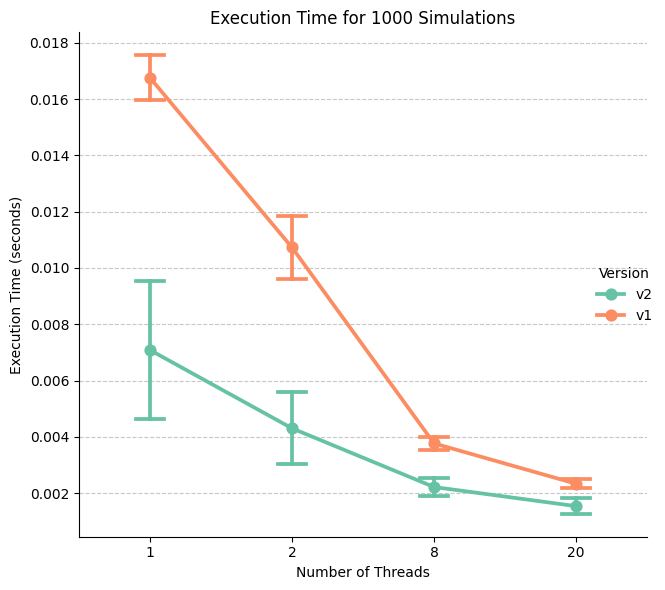

<Figure size 1200x600 with 0 Axes>

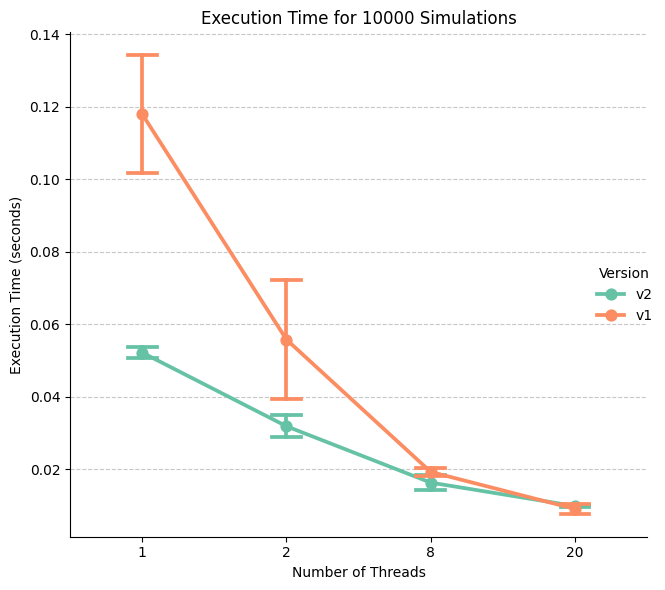

<Figure size 1200x600 with 0 Axes>

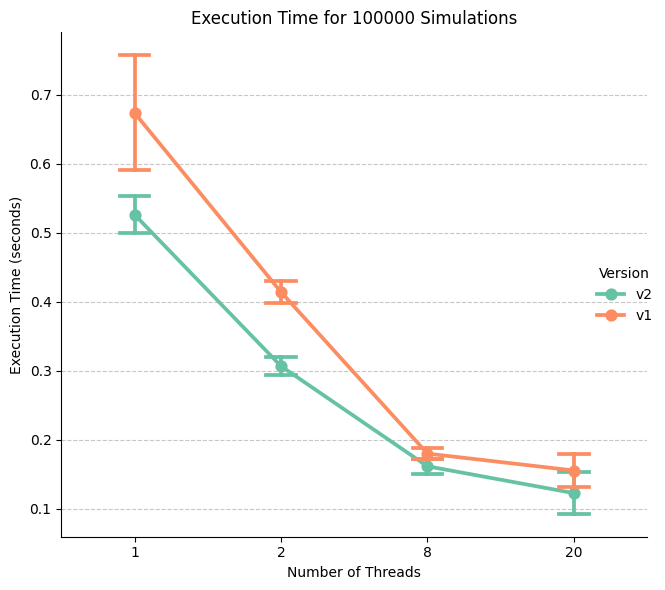

<Figure size 1200x600 with 0 Axes>

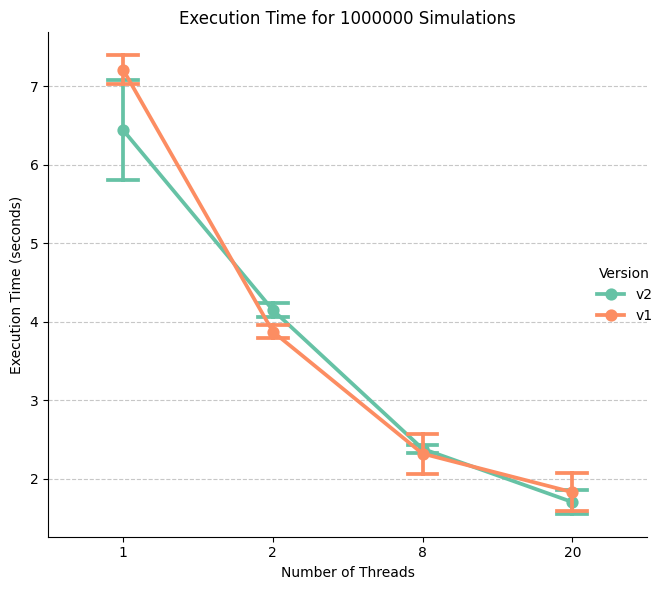

In [206]:
generate_curve_per_nb_thread(df)

<Figure size 1200x600 with 0 Axes>

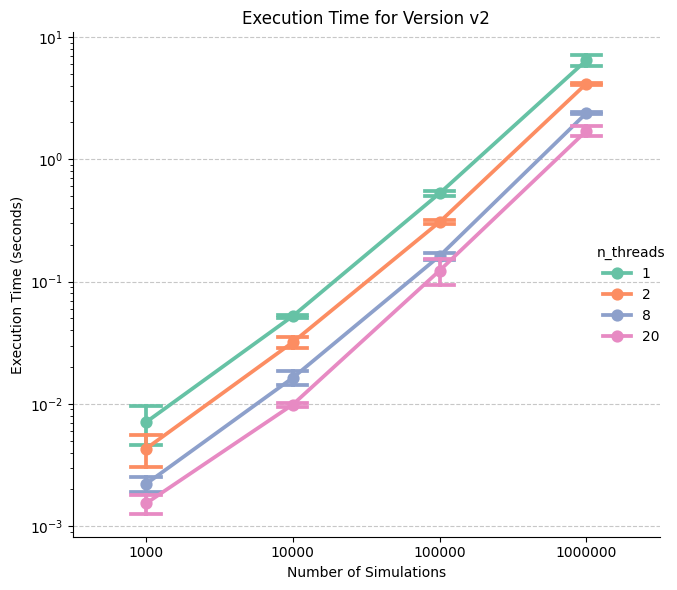

<Figure size 1200x600 with 0 Axes>

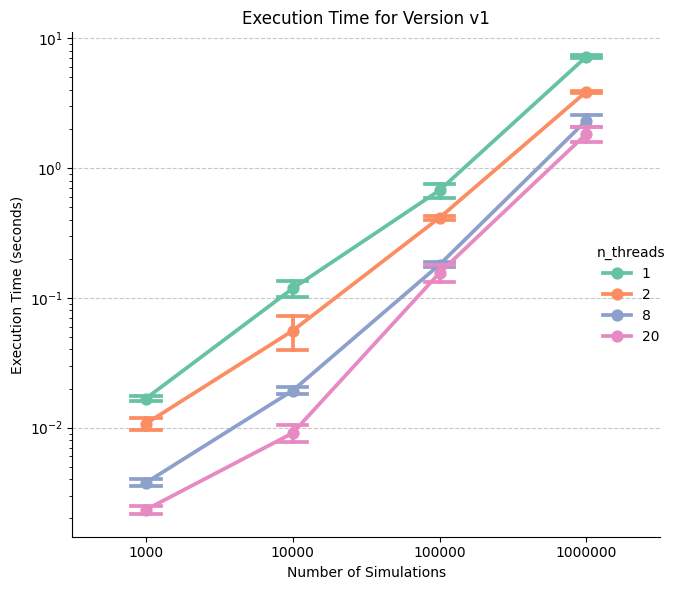

In [205]:
generate_curve_per_nb_sim(df)

## Simulations on GPU

In [ ]:
monte_carlo_cuda_paths = ["monte_carlo_cuda_1", "monte_carlo_cuda_2"]
nb_simul_list = [1000, 10000, 100000, 1000000]
simul_length_list = [252]